In [153]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, TensorDataset 

import sys
sys.path.append("..")
import src.utils as utils

import pandas as pd

In [75]:
## REGRESION

# Sample Dataset Class
class TimeSeriesDataset(Dataset):
    def __init__(self, data, targets, seq_len):
        """
        Args:
            data (torch.Tensor): Input data of shape (num_samples, seq_len, num_features)
            targets (torch.Tensor): Target data of shape (num_samples,)
            seq_len (int): Sequence length
        """
        self.data = data
        self.targets = targets
        self.seq_len = seq_len

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.targets[idx]

# CNN Module
class CNNBlock_Reg(nn.Module):
    def __init__(self, input_channels, num_filters, kernel_size):
        super(CNNBlock_Reg, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=input_channels, out_channels=num_filters, kernel_size=kernel_size, padding=kernel_size // 2)
        self.conv2 = nn.Conv1d(in_channels=num_filters, out_channels=num_filters, kernel_size=kernel_size, padding=kernel_size // 2)
        self.pool = nn.AdaptiveAvgPool1d(1)

    def forward(self, x):
        """
        Args:
            x (torch.Tensor): Input of shape (batch_size, seq_len, num_features)
        Returns:
            torch.Tensor: Output features (batch_size, num_filters)
        """
        x = x.permute(0, 2, 1)  # Change to (batch_size, num_features, seq_len)
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool(x).squeeze(-1)  # Global average pooling
        return x

# Temporal Fusion Transformer (simplified for demonstration)
class TemporalFusionTransformer_Reg(nn.Module):
    def __init__(self, input_size, hidden_size, num_heads, num_layers):
        super(TemporalFusionTransformer_Reg, self).__init__()
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=hidden_size, nhead=num_heads, dim_feedforward=256)
        self.transformer = nn.TransformerEncoder(self.encoder_layer, num_layers=num_layers)
        self.input_projection = nn.Linear(input_size, hidden_size)
        self.output_projection = nn.Linear(hidden_size, hidden_size)

    def forward(self, x):
        """
        Args:
            x (torch.Tensor): Input of shape (batch_size, seq_len, input_size)
        Returns:
            torch.Tensor: Output features (batch_size, hidden_size)
        """
        x = self.input_projection(x)
        x = x.permute(1, 0, 2)  # Change to (seq_len, batch_size, hidden_size) for Transformer
        x = self.transformer(x)
        x = x.mean(dim=0)  # Aggregate across sequence length
        x = self.output_projection(x)
        return x

# Hybrid Model
class HybridTFTCNN_Reg(nn.Module):
    def __init__(self, input_size, cnn_filters, kernel_size, transformer_hidden_size, num_heads, num_layers, output_size):
        super(HybridTFTCNN_Reg, self).__init__()
        self.cnn_block = CNNBlock_Reg(input_channels=input_size, num_filters=cnn_filters, kernel_size=kernel_size)
        self.tft_block = TemporalFusionTransformer_Reg(input_size=input_size, hidden_size=transformer_hidden_size, num_heads=num_heads, num_layers=num_layers)
        self.final_fc = nn.Linear(cnn_filters + transformer_hidden_size, output_size)

    def forward(self, x):
        """
        Args:
            x (torch.Tensor): Input of shape (batch_size, seq_len, input_size)
        Returns:
            torch.Tensor: Output prediction (batch_size, output_size)
        """
        cnn_features = self.cnn_block(x)
        tft_features = self.tft_block(x)
        combined_features = torch.cat([cnn_features, tft_features], dim=-1)
        output = self.final_fc(combined_features)
        return output

    def predict(self, X):
        """
        Args:
            X (torch.Tensor or np.ndarray): Input data of shape (batch_size, seq_len, input_size)
        Returns:
            np.ndarray: Predicted output values
        """
        # Ensure the model is in evaluation mode
        self.eval()

        # Convert input to torch tensor if it's a NumPy array
        if isinstance(X, np.ndarray):
            X = torch.tensor(X, dtype=torch.float32)

        # Use no_grad to disable gradient computation during prediction
        with torch.no_grad():
            predictions = self.forward(X)

        # Convert predictions to a NumPy array and return
        return predictions.numpy()

# # Example Usage
# if __name__ == "__main__":
#     # Dummy Data
#     num_samples = 1000
#     seq_len = 24
#     num_features = 10
#     x_data = torch.randn(num_samples, seq_len, num_features)
#     y_data = torch.randn(num_samples, 1)

#     # Dataset and DataLoader
#     dataset = TimeSeriesDataset(x_data, y_data, seq_len=seq_len)
#     dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

#     # Model
#     model = HybridTFTCNN(
#         input_size=num_features,
#         cnn_filters=16,
#         kernel_size=3,
#         transformer_hidden_size=32,
#         num_heads=4,
#         num_layers=2,
#         output_size=1
#     )

#     # Training Setup
#     criterion = nn.MSELoss()
#     optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

#     # Training Loop
#     for epoch in range(10):
#         model.train()
#         epoch_loss = 0
#         for x_batch, y_batch in dataloader:
#             optimizer.zero_grad()
#             predictions = model(x_batch)
#             loss = criterion(predictions, y_batch)
#             loss.backward()
#             optimizer.step()
#             epoch_loss += loss.item()

#         print(f"Epoch {epoch + 1}, Loss: {epoch_loss / len(dataloader):.4f}")


In [ ]:
### CLASIFICACION


# Define the CNN Block
class CNNBlock_Class(nn.Module):
    def __init__(self, input_dim, cnn_channels, kernel_size=3):
        super(CNNBlock_Class, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv1d(in_channels=input_dim, out_channels=cnn_channels, kernel_size=kernel_size, padding=kernel_size//2),
            nn.ReLU(),
            nn.Conv1d(in_channels=cnn_channels, out_channels=cnn_channels, kernel_size=kernel_size, padding=kernel_size//2),
            nn.ReLU(),
        )

    def forward(self, x):
        # Expecting input shape: (batch_size, seq_len, input_dim)
        x = x.permute(0, 2, 1)  # Reshape to (batch_size, input_dim, seq_len) for Conv1D
        x = self.cnn(x)
        x = x.permute(0, 2, 1)  # Reshape back to (batch_size, seq_len, cnn_channels)
        return x

# Define the Temporal Fusion Transformer (TFT) Block
class TFTBlock_Class(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_heads, dropout=0.1):
        super(TFTBlock_Class, self).__init__()
        self.multihead_attn = nn.MultiheadAttention(embed_dim=input_dim, num_heads=num_heads, dropout=dropout)
        self.feed_forward = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim),
        )
        self.norm1 = nn.LayerNorm(input_dim)
        self.norm2 = nn.LayerNorm(input_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # Expecting input shape: (seq_len, batch_size, input_dim)
        attn_output, _ = self.multihead_attn(x, x, x)
        x = self.norm1(x + self.dropout(attn_output))
        ff_output = self.feed_forward(x)
        x = self.norm2(x + self.dropout(ff_output))
        return x

# Combine CNN and TFT into a Hybrid Model
class HybridTFTCNN_Class(nn.Module):
    def __init__(self, input_dim, cnn_channels, tft_hidden_dim, tft_heads, seq_len, output_dim, dropout=0.1):
        super(HybridTFTCNN_Class, self).__init__()
        self.cnn_block = CNNBlock_Class(input_dim, cnn_channels)
        self.tft_block = TFTBlock_Class(input_dim=cnn_channels, hidden_dim=tft_hidden_dim, num_heads=tft_heads, dropout=dropout)
        self.output_layer = nn.Sequential(
            nn.Flatten(),
            nn.Linear(seq_len * cnn_channels, 128),
            nn.ReLU(),
            nn.Linear(128, output_dim)
        )

    def forward(self, x):
        # Input shape: (batch_size, seq_len, input_dim)
        x = self.cnn_block(x)  # (batch_size, seq_len, cnn_channels)
        x = x.permute(1, 0, 2)  # Reshape to (seq_len, batch_size, cnn_channels) for TFT
        x = self.tft_block(x)  # (seq_len, batch_size, cnn_channels)
        x = x.permute(1, 0, 2)  # Reshape back to (batch_size, seq_len, cnn_channels)
        x = self.output_layer(x)  # Final output
        return x

# Example Usage
if __name__ == "__main__":
    # Hyperparameters
    input_dim = 10       # Number of input features
    cnn_channels = 16    # Number of CNN output channels
    tft_hidden_dim = 32  # Hidden dimension in TFT block
    tft_heads = 4        # Number of attention heads in TFT block
    seq_len = 24         # Sequence length (e.g., 24 hours)
    output_dim = 1       # Number of outputs (e.g., regression target)
    dropout = 0.1

    # Create the model
    model = HybridTFTCNN_Class(input_dim, cnn_channels, tft_hidden_dim, tft_heads, seq_len, output_dim, dropout)

    # Example Input: Batch of 32 sequences, each of length 24, with 10 features
    example_input = torch.randn(32, seq_len, input_dim)

    # Forward Pass
    output = model(example_input)
    print("Output shape:", output.shape)  # Expected: (32, output_dim)

Output shape: torch.Size([32, 1])


In [60]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from torch.utils.data import Dataset, DataLoader

def preprocess_data(df, target_col, seq_len, categorical_cols, continuous_cols):
    """
    Prepares the dataset for the Hybrid TFT-CNN model.
    
    Args:
        df (pd.DataFrame): Input dataframe.
        target_col (str): Name of the target column.
        seq_len (int): Sequence length for time-series data.
        categorical_cols (list): List of categorical column names.
        continuous_cols (list): List of continuous column names.
    
    Returns:
        np.array: Sequences of input features (num_samples, seq_len, num_features).
        np.array: Corresponding target values (num_samples,).
    """
    # Encode categorical variables
    for col in categorical_cols:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col])

    # Normalize continuous variables
    scaler = MinMaxScaler()
    df[continuous_cols] = scaler.fit_transform(df[continuous_cols])

    # Create sequences
    sequences = []
    targets = []
    for i in range(len(df) - seq_len):
        seq_x = df.iloc[i:i + seq_len][np.concatenate([categorical_cols,continuous_cols])].values
        seq_y = df.iloc[i + seq_len][target_col]
        sequences.append(seq_x)
        targets.append(seq_y)

    return np.array(sequences), np.array(targets)




In [80]:
df = pd.read_csv(r'../data/df_final_metadata.csv')
df = df.sort_values(by='fecha_hora', ascending=True)
dt = df['fecha_hora'].copy()
y_real = df['cmg'].copy()
df = df.iloc[:,1:].copy()

df

,cmg,demanda,gx_Eólicas_Antofagasta,gx_Eólicas_Araucanía,gx_Eólicas_Atacama,gx_Eólicas_Biobío,gx_Eólicas_Coquimbo,gx_Eólicas_Los Lagos,gx_Eólicas_O’Higgins,gx_Solares_Antofagasta,...,emb_MELADO,emb_PANGUE,emb_POLCURA,emb_RALCO,emb_RAPEL,year,month,day,day_of_week,hour
0,55.52,7992.914520,89.92,71.65,26.40,57.09,459.92,26.54,3.03,0.00,...,643.47,509.02,735.55,715.75,103.52,2019,1,1,1,0
1,55.52,7948.664819,72.62,79.50,10.70,58.19,388.12,22.47,1.76,0.00,...,643.63,508.90,735.57,715.75,103.52,2019,1,1,1,1
2,55.52,7752.115956,35.16,77.97,1.90,48.44,304.78,13.95,0.65,0.00,...,643.79,508.81,735.60,715.73,103.52,2019,1,1,1,2
3,55.52,7523.577425,17.75,66.52,0.00,39.39,252.67,13.50,1.51,0.00,...,643.94,508.74,735.62,715.73,103.52,2019,1,1,1,3
4,55.52,7308.782546,8.89,51.07,0.00,41.75,278.55,15.77,3.25,0.00,...,644.08,508.75,735.62,715.73,103.52,2019,1,1,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48131,0.00,9228.687500,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,645.91,508.77,735.03,721.98,104.52,2024,6,28,4,15
48132,9.03,9903.786133,474.64,262.98,127.24,288.62,286.39,5.97,36.77,1493.65,...,645.92,508.71,735.07,722.04,104.53,2024,6,28,4,16
48133,35.36,10463.607422,494.72,477.75,74.94,317.90,178.76,6.89,69.48,407.73,...,645.83,508.72,734.94,722.07,104.50,2024,6,28,4,17
48134,69.48,10986.050781,303.65,654.46,28.13,365.90,85.30,2.12,71.48,166.14,...,645.78,508.71,734.92,722.07,104.51,2024,6,28,4,18


In [129]:
# Define a split point (e.g., 80% train, 20% test)
split_point = int(0.9 * len(df))

# Split the data
train_val_df = df[:split_point].copy()
test_df = df[split_point:].copy()
test_dt = dt[split_point:].copy()
test_cmg = y_real[split_point:].copy()

In [130]:
split_point_val = int(0.8 * len(train_val_df))  # 80% train, 20% validation
train_df = train_val_df[:split_point_val].copy()
val_df = train_val_df[split_point_val:].copy()

In [64]:
# Example columns
categorical_cols = train_df.columns[-5:].copy()
continuous_cols = train_df.columns[1:-5].copy()

# Generate sequences
seq_len = 32  # Sequence length (e.g., daily for hourly data)
X, y = preprocess_data(train_df, target_col='cmg', seq_len=seq_len, categorical_cols=categorical_cols, continuous_cols=continuous_cols)

# Convert to DataLoader
class CMGDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

dataset = CMGDataset(X, y)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

In [131]:
X_val, y_val = preprocess_data(
    val_df,
    target_col='cmg',
    seq_len=seq_len,
    categorical_cols=categorical_cols,
    continuous_cols=continuous_cols,
)

In [135]:
val_dataset = TensorDataset(
    torch.tensor(X_val, dtype=torch.float32),
    torch.tensor(y_val, dtype=torch.float32)
)

In [136]:
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=False)

In [168]:
num_features = X.shape[2]  # Total features per time step
model = HybridTFTCNN_Reg(
    input_size=num_features,       # Total features (categorical + continuous)
    cnn_filters=32,                # Number of CNN filters
    kernel_size=3,                 # CNN kernel size
    transformer_hidden_size=64,    # Hidden size for TFT
    num_heads=4,                   # Attention heads
    num_layers=2,                  # Number of Transformer layers
    output_size=1                  # Single regression target
)

c:\Users\gigle\anaconda3\envs\mia\Lib\site-packages\torch\nn\modules\transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


In [69]:
# Training Loop
criterion = nn.MSELoss()  # Regression loss
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

for epoch in range(20):  # Number of epochs
    model.train()
    epoch_loss = 0
    for X_batch, y_batch in dataloader:
        optimizer.zero_grad()
        predictions = model(X_batch)
        loss = criterion(predictions.squeeze(-1), y_batch)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    print(f"Epoch {epoch + 1}, Loss: {epoch_loss / len(dataloader):.4f}")

Epoch 1, Loss: 2303.7112
Epoch 2, Loss: 1446.2472
Epoch 3, Loss: 1337.3529
Epoch 4, Loss: 1252.1016
Epoch 5, Loss: 1184.4239
Epoch 6, Loss: 1131.5276
Epoch 7, Loss: 1089.8480
Epoch 8, Loss: 1036.9404
Epoch 9, Loss: 1001.7612
Epoch 10, Loss: 980.6072
Epoch 11, Loss: 934.6766
Epoch 12, Loss: 947.8153
Epoch 13, Loss: 896.9920
Epoch 14, Loss: 896.3906
Epoch 15, Loss: 865.3242
Epoch 16, Loss: 858.4259
Epoch 17, Loss: 835.5689
Epoch 18, Loss: 810.0777
Epoch 19, Loss: 810.8415
Epoch 20, Loss: 804.6304


In [154]:
## Training Loop 2.0

import torch.nn.functional as F
from sklearn.metrics import mean_absolute_error

# Variables to track the best model
best_valid_loss = float('inf')
best_model_weights = None

for epoch in range(200):  # Number of epochs
    # Training phase
    model.train()
    epoch_loss = 0
    for X_batch, y_batch in dataloader:
        optimizer.zero_grad()
        predictions = model(X_batch)
        loss = criterion(predictions.squeeze(-1), y_batch)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    train_loss = epoch_loss / len(dataloader)

    # Validation phase
    model.eval()
    valid_loss = 0
    all_y_pred = []
    all_y_true = []

    with torch.no_grad():
        for X_val, y_val in val_dataloader:  # Use a separate dataloader for validation data
            val_predictions = model(X_val)
            val_loss = criterion(val_predictions.squeeze(-1), y_val)
            valid_loss += val_loss.item()

            # Store predictions and true values for MAE calculation
            all_y_pred.extend(val_predictions.squeeze(-1).tolist())
            all_y_true.extend(y_val.tolist())

    valid_loss /= len(val_dataloader)
    valid_mae = mean_absolute_error(all_y_true, all_y_pred)

    # Save the best model weights
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        best_model_weights = model.state_dict()  # Save the weights of the best model

    print(
        f"Epoch {epoch + 1}, "
        f"Train Loss: {train_loss:.4f}, "
        f"Valid Loss: {valid_loss:.4f}, "
        f"Valid MAE: {valid_mae:.4f}"
    )

# Load the best model weights after training
if best_model_weights:
    model.load_state_dict(best_model_weights)


Epoch 1, Train Loss: 643.4184, Valid Loss: 22219.2788, Valid MAE: 106.5081
Epoch 2, Train Loss: 640.7020, Valid Loss: 19114.1935, Valid MAE: 96.5069
Epoch 3, Train Loss: 627.9020, Valid Loss: 24403.3376, Valid MAE: 112.7129
Epoch 4, Train Loss: 612.5366, Valid Loss: 22774.9399, Valid MAE: 108.4608
Epoch 5, Train Loss: 630.8468, Valid Loss: 24927.4209, Valid MAE: 114.9141
Epoch 6, Train Loss: 628.4657, Valid Loss: 25035.1315, Valid MAE: 120.4652
Epoch 7, Train Loss: 593.3188, Valid Loss: 23064.3483, Valid MAE: 110.7939
Epoch 8, Train Loss: 584.3290, Valid Loss: 25354.1414, Valid MAE: 121.3566
Epoch 9, Train Loss: 589.5970, Valid Loss: 20803.4168, Valid MAE: 106.1593
Epoch 10, Train Loss: 566.8077, Valid Loss: 20122.9589, Valid MAE: 101.6593
Epoch 11, Train Loss: 579.4467, Valid Loss: 22899.1225, Valid MAE: 109.1194
Epoch 12, Train Loss: 565.5669, Valid Loss: 25590.7006, Valid MAE: 116.2750
Epoch 13, Train Loss: 558.2258, Valid Loss: 24237.8160, Valid MAE: 112.6568
Epoch 14, Train Loss: 

In [155]:
X_test, y_test = preprocess_data(
    test_df,
    target_col='cmg',
    seq_len=seq_len,
    categorical_cols=categorical_cols,
    continuous_cols=continuous_cols
)

HybridTFTCNN_Reg(
  (cnn_block): CNNBlock_Reg(
    (conv1): Conv1d(109, 32, kernel_size=(3,), stride=(1,), padding=(1,))
    (conv2): Conv1d(32, 32, kernel_size=(3,), stride=(1,), padding=(1,))
    (pool): AdaptiveAvgPool1d(output_size=1)
  )
  (tft_block): TemporalFusionTransformer_Reg(
    (encoder_layer): TransformerEncoderLayer(
      (self_attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
      )
      (linear1): Linear(in_features=64, out_features=256, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
      (linear2): Linear(in_features=256, out_features=64, bias=True)
      (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (dropout1): Dropout(p=0.1, inplace=False)
      (dropout2): Dropout(p=0.1, inplace=False)
    )
    (transformer): TransformerEncoder(
      (layers): ModuleList(
        (0-1): 2 x TransformerEn

In [156]:
# # Get predictions
# y_pred = model.predict(X_test)

# # Flatten predictions if needed (e.g., if predictions are in shape (N, 1))
# y_pred = y_pred.flatten()

In [157]:
# Ensure the model is in evaluation mode
model.eval()

# Convert test data to a PyTorch tensor
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)

# Disable gradient computation during prediction
with torch.no_grad():
    y_pred_tensor = model(X_test_tensor)

# Convert predictions back to a NumPy array
y_pred = y_pred_tensor.numpy()

In [158]:
y_pred

array([[-167.93973 ],
       [-171.58815 ],
       [-181.19513 ],
       ...,
       [  61.612312],
       [ 123.06505 ],
       [ 129.72208 ]], dtype=float32)

In [159]:
y_pred = y_pred.flatten()

# Adjust test_dt and test_cmg to match the reduced length after preprocessing
adjusted_test_dt = test_dt.iloc[seq_len:].reset_index(drop=True)
adjusted_test_cmg = test_cmg.iloc[seq_len:].reset_index(drop=True)

# Create the combined DataFrame
result_df = pd.DataFrame({
    'datetime': adjusted_test_dt,
    'y_real': adjusted_test_cmg,
    'y_pred': y_pred
})

# result_df.loc[result_df['y_pred'] <= 0, 'y_pred'] = 0

In [160]:
result_df['model'] = 'tft-cnn_v01_2_200epochs'
result_df

,datetime,y_real,y_pred,model
0,2023-12-12 14:00:00,0.00,-167.939728,tft-cnn_v01_2_200epochs
1,2023-12-12 15:00:00,0.00,-171.588150,tft-cnn_v01_2_200epochs
2,2023-12-12 16:00:00,0.00,-181.195129,tft-cnn_v01_2_200epochs
3,2023-12-12 17:00:00,0.00,-187.146301,tft-cnn_v01_2_200epochs
4,2023-12-12 18:00:00,0.00,-183.827805,tft-cnn_v01_2_200epochs
...,...,...,...,...
4777,2024-06-28 15:00:00,0.00,114.781891,tft-cnn_v01_2_200epochs
4778,2024-06-28 16:00:00,9.03,125.802612,tft-cnn_v01_2_200epochs
4779,2024-06-28 17:00:00,35.36,61.612312,tft-cnn_v01_2_200epochs
4780,2024-06-28 18:00:00,69.48,123.065048,tft-cnn_v01_2_200epochs


In [161]:
result_df.describe()

,y_real,y_pred
count,4782.000000,4782.000000
mean,55.365004,17.130241
std,51.865822,94.597137
min,0.000000,-243.282974
25%,0.000000,-54.782177
50%,67.740000,29.024710
75%,86.267500,95.353283
max,347.930000,248.262878


In [162]:
# Append the result_df to the existing CSV
result_df.to_csv('./test_results/tests_consolidated.csv', mode='a', index=False, header=False)


In [163]:
len(adjusted_test_cmg)

4782

In [164]:
result_df.rename(columns={'y_real': 'real',
                          'y_pred': 'pred'}, inplace=True)

kpis, kpi_summary = utils.calculate_kpis(result_df, 'datetime', 6, 32)
kpis

,datetime,real,pred,model,fecha_eval,correlative,coincidence,charge_real,charge_pred,discharge_real,discharge_pred,revenue_real,revenue_pred,mae,rmse,bias
0,2023-12-12 14:00:00,0.00,-167.939728,tft-cnn_v01_2_200epochs,2023-12-12,1,1,1,1,1,1,0.00,0.00,167.939728,167.939728,-167.939728
1,2023-12-12 15:00:00,0.00,-171.588150,tft-cnn_v01_2_200epochs,2023-12-12,2,0,1,1,0,1,0.00,0.00,171.588150,171.588150,-171.588150
2,2023-12-12 16:00:00,0.00,-181.195129,tft-cnn_v01_2_200epochs,2023-12-12,3,1,1,1,0,0,0.00,0.00,181.195129,181.195129,-181.195129
3,2023-12-12 17:00:00,0.00,-187.146301,tft-cnn_v01_2_200epochs,2023-12-12,4,1,1,1,0,0,0.00,0.00,187.146301,187.146301,-187.146301
4,2023-12-12 18:00:00,0.00,-183.827805,tft-cnn_v01_2_200epochs,2023-12-12,5,1,1,1,0,0,0.00,0.00,183.827805,183.827805,-183.827805
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4777,2024-06-28 15:00:00,0.00,114.781891,tft-cnn_v01_2_200epochs,2024-06-28,16,0,1,0,0,0,0.00,0.00,114.781891,114.781891,114.781891
4778,2024-06-28 16:00:00,9.03,125.802612,tft-cnn_v01_2_200epochs,2024-06-28,17,0,1,0,0,0,-9.03,0.00,116.772612,116.772612,116.772612
4779,2024-06-28 17:00:00,35.36,61.612312,tft-cnn_v01_2_200epochs,2024-06-28,18,0,0,1,0,0,0.00,-35.36,26.252312,26.252312,26.252312
4780,2024-06-28 18:00:00,69.48,123.065048,tft-cnn_v01_2_200epochs,2024-06-28,19,0,0,0,1,0,69.48,0.00,53.585048,53.585048,53.585048


In [165]:
kpi_summary.describe()

,factor_coincidence,factor_value,mae,rmse,bias
count,200.000000,200.000000,200.000000,200.000000,200.000000
mean,0.480958,0.764932,72.220736,72.220736,-38.580981
std,0.185730,0.248085,50.999107,50.999107,77.192942
min,0.083333,-0.393167,11.640179,11.640179,-200.354950
25%,0.333333,0.668391,35.613932,35.613932,-89.505232
50%,0.500000,0.857259,56.420861,56.420861,-25.059265
75%,0.583333,0.939866,92.082950,92.082950,24.444116
max,0.916667,1.000000,200.354950,200.354950,91.071982


In [166]:
kpis.to_csv('./test_results/kpis_consolidated.csv', mode='a', index=False, header=False)

In [178]:
result_df

,datetime,real,pred,model,fecha_eval
0,2023-12-12 14:00:00,0.00,-167.939728,tft-cnn_v01_2_200epochs,2023-12-12
1,2023-12-12 15:00:00,0.00,-171.588150,tft-cnn_v01_2_200epochs,2023-12-12
2,2023-12-12 16:00:00,0.00,-181.195129,tft-cnn_v01_2_200epochs,2023-12-12
3,2023-12-12 17:00:00,0.00,-187.146301,tft-cnn_v01_2_200epochs,2023-12-12
4,2023-12-12 18:00:00,0.00,-183.827805,tft-cnn_v01_2_200epochs,2023-12-12
...,...,...,...,...,...
4777,2024-06-28 15:00:00,0.00,114.781891,tft-cnn_v01_2_200epochs,2024-06-28
4778,2024-06-28 16:00:00,9.03,125.802612,tft-cnn_v01_2_200epochs,2024-06-28
4779,2024-06-28 17:00:00,35.36,61.612312,tft-cnn_v01_2_200epochs,2024-06-28
4780,2024-06-28 18:00:00,69.48,123.065048,tft-cnn_v01_2_200epochs,2024-06-28


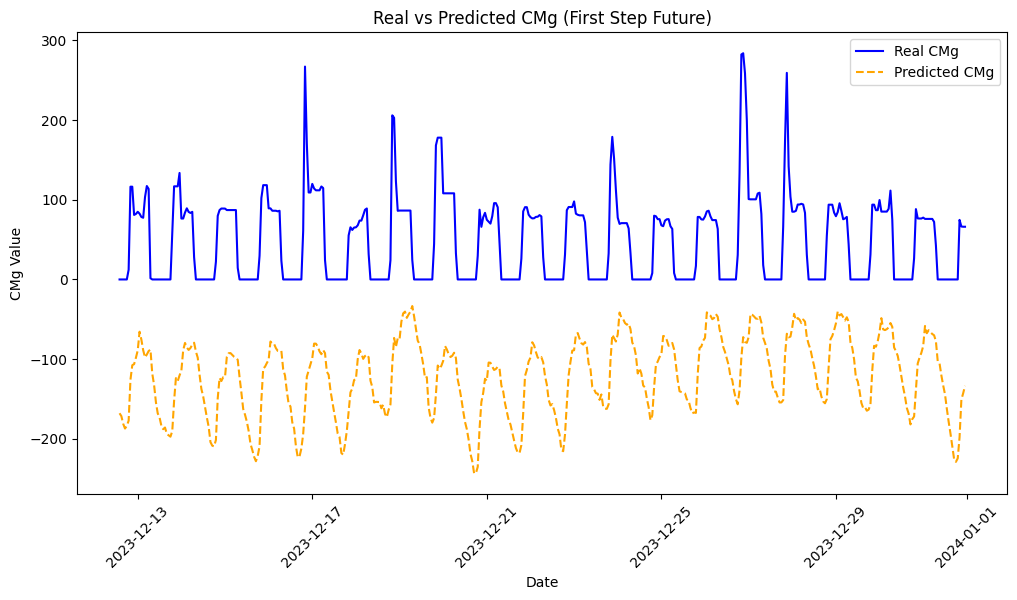

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt 

# Filter data for December 2023
plot_sample = result_df[(result_df['datetime'].dt.year == 2023) & (result_df['datetime'].dt.month == 12)]

# # Plot the actual 'real' values
# sns.lineplot(x='datetime', y='real', data=plot_sample, label='Real')

# # Plot the predicted 'pred' values
# sns.lineplot(x='datetime', y='pred', data=plot_sample, label='Pred')

# # Add y-axis label
# plt.ylabel('CMg')
# plt.xlabel('Time')

plt.figure(figsize=(12, 6))
plt.plot(plot_sample['datetime'], plot_sample['real'], label='Real CMg', color='blue')
plt.plot(plot_sample['datetime'], plot_sample['pred'], label='Predicted CMg', color='orange', linestyle='--')
plt.title('Real vs Pred')
plt.xlabel('Date')
plt.ylabel('CMg Value')
plt.legend()
plt.grid(False)
plt.xticks(rotation=45)



# Display the legend
plt.legend()

# Show the plot
plt.show()


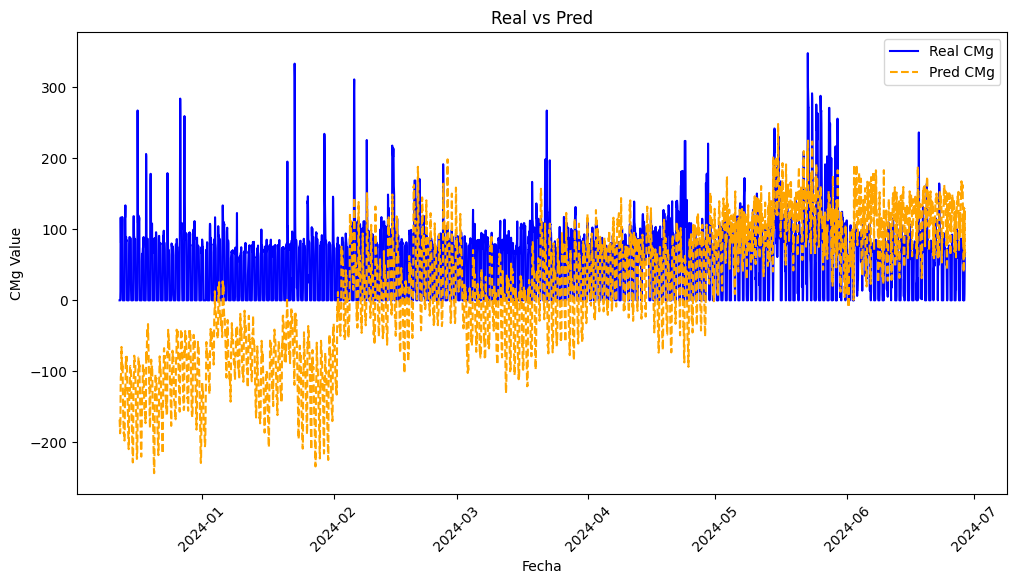

In [221]:
plt.figure(figsize=(12, 6))
plt.plot(result_df['datetime'], result_df['real'], label='Real CMg', color='blue')
plt.plot(result_df['datetime'], result_df['pred'], label='Pred CMg', color='orange', linestyle='--')
plt.title('Real vs Pred')
plt.xlabel('Fecha')
plt.ylabel('CMg Value')
plt.legend()
plt.grid(False)
plt.xticks(rotation=45)



# Display the legend
plt.legend()

# Show the plot
plt.show()

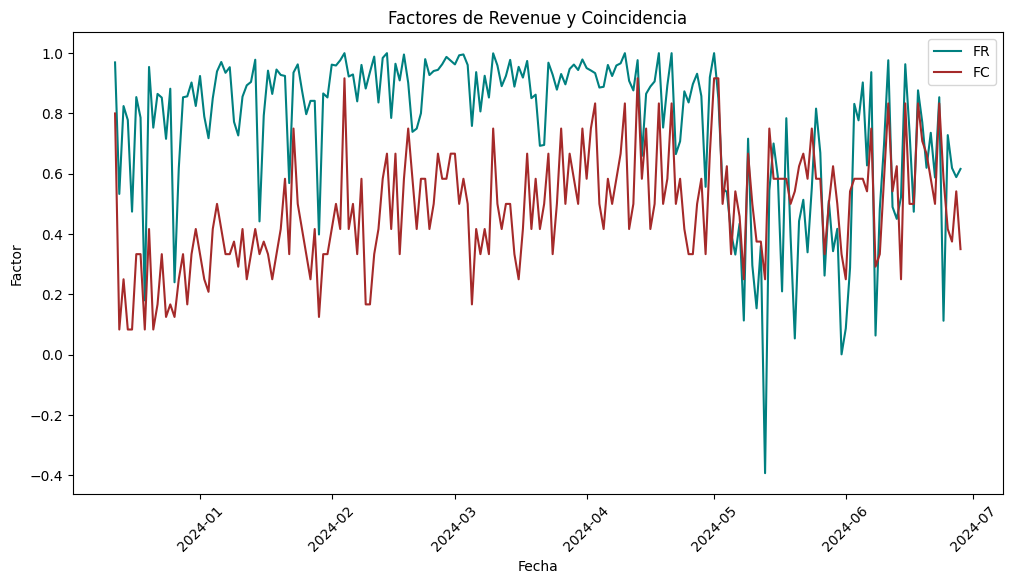

In [220]:
plt.figure(figsize=(12, 6))
plt.plot(kpi_summary['date'], kpi_summary['factor_value'], label='FR', color='teal')
plt.plot(kpi_summary['date'], kpi_summary['factor_coincidence'], label='FC', color='brown')
plt.title('Factores de Revenue y Coincidencia')
plt.xlabel('Fecha')
plt.ylabel('Factor')
plt.legend()
plt.grid(False)
plt.xticks(rotation=45)



# Display the legend
plt.legend()

# Show the plot
plt.show()

In [217]:
kpi_summary['date'].dt.isocalendar().week

0      50
1      50
2      50
3      50
4      50
       ..
195    26
196    26
197    26
198    26
199    26
Name: week, Length: 200, dtype: UInt32

In [232]:
kpi_summary['date'] = pd.to_datetime(kpi_summary['date'])

kpi_sample = kpi_summary[(kpi_summary['date'].dt.year == 2023) & (kpi_summary['date'].dt.month == 12)]
kpi_sample

,date,factor_coincidence,factor_value,mae,rmse,bias
0,2023-12-12,0.800000,0.969308,191.533034,192.812888,-191.533034
1,2023-12-13,0.083333,0.533054,187.306118,192.184097,-187.306118
2,2023-12-14,0.250000,0.824592,172.332974,176.682087,-172.332974
3,2023-12-15,0.083333,0.778295,193.934047,197.049754,-193.934047
4,2023-12-16,0.083333,0.474333,194.426190,204.811706,-194.426190
5,2023-12-17,0.333333,0.854273,185.605789,188.383913,-185.605789
6,2023-12-18,0.333333,0.786227,175.199067,179.847497,-175.199067
7,2023-12-19,0.083333,0.179901,151.107591,168.772553,-151.107591
8,2023-12-20,0.416667,0.954241,200.354950,203.896245,-200.354950
9,2023-12-21,0.083333,0.752963,191.719348,193.764630,-191.719348


In [233]:
kpi_sample.describe()

,date,factor_coincidence,factor_value,mae,rmse,bias
count,20,20.000000,20.000000,20.000000,20.000000,20.000000
mean,2023-12-21 12:00:00,0.248333,0.735941,169.318518,175.090083,-169.318518
min,2023-12-12 00:00:00,0.083333,0.179901,135.782475,140.086136,-200.354950
25%,2023-12-16 18:00:00,0.114583,0.691414,150.979739,162.789709,-188.362847
50%,2023-12-21 12:00:00,0.208333,0.824724,170.667099,178.117909,-170.667099
75%,2023-12-26 06:00:00,0.333333,0.858836,188.362847,192.341295,-150.979739
max,2023-12-31 00:00:00,0.800000,0.969308,200.354950,204.811706,-135.782475
std,NaN,0.175273,0.220445,20.586263,20.395728,20.586263


In [205]:
kpis['fecha_eval'] = pd.to_datetime(kpis['fecha_eval'])

kpis[kpis['fecha_eval']=='2023-12-19']

,datetime,real,pred,model,fecha_eval,correlative,coincidence,charge_real,charge_pred,discharge_real,discharge_pred,revenue_real,revenue_pred,mae,rmse,bias
154,2023-12-19 00:00:00,86.49,-75.210983,tft-cnn_v01_2_200epochs,2023-12-19,1,0,0,0,1,0,86.49,0.00,161.700983,161.700983,-161.700983
155,2023-12-19 01:00:00,86.49,-52.983685,tft-cnn_v01_2_200epochs,2023-12-19,2,0,0,0,1,0,86.49,0.00,139.473685,139.473685,-139.473685
156,2023-12-19 02:00:00,86.49,-42.534084,tft-cnn_v01_2_200epochs,2023-12-19,3,0,0,0,0,1,0.00,86.49,129.024084,129.024084,-129.024084
157,2023-12-19 03:00:00,86.49,-40.366375,tft-cnn_v01_2_200epochs,2023-12-19,4,0,0,0,0,1,0.00,86.49,126.856375,126.856375,-126.856375
158,2023-12-19 04:00:00,86.49,-48.221371,tft-cnn_v01_2_200epochs,2023-12-19,5,1,0,0,0,0,0.00,0.00,134.711371,134.711371,-134.711371
159,2023-12-19 05:00:00,86.49,-43.848003,tft-cnn_v01_2_200epochs,2023-12-19,6,0,0,0,0,1,0.00,86.49,130.338003,130.338003,-130.338003
160,2023-12-19 06:00:00,86.49,-40.347698,tft-cnn_v01_2_200epochs,2023-12-19,7,0,0,0,0,1,0.00,86.49,126.837698,126.837698,-126.837698
161,2023-12-19 07:00:00,24.42,-33.377071,tft-cnn_v01_2_200epochs,2023-12-19,8,0,0,0,0,1,0.00,24.42,57.797071,57.797071,-57.797071
162,2023-12-19 08:00:00,0.00,-46.266468,tft-cnn_v01_2_200epochs,2023-12-19,9,0,1,0,0,1,0.00,0.00,46.266468,46.266468,-46.266468
163,2023-12-19 09:00:00,0.00,-61.446644,tft-cnn_v01_2_200epochs,2023-12-19,10,0,1,0,0,0,0.00,0.00,61.446644,61.446644,-61.446644


In [200]:
kpis

,datetime,real,pred,model,fecha_eval,correlative,coincidence,charge_real,charge_pred,discharge_real,discharge_pred,revenue_real,revenue_pred,mae,rmse,bias
0,2023-12-12 14:00:00,0.00,-167.939728,tft-cnn_v01_2_200epochs,2023-12-12,1,1,1,1,1,1,0.00,0.00,167.939728,167.939728,-167.939728
1,2023-12-12 15:00:00,0.00,-171.588150,tft-cnn_v01_2_200epochs,2023-12-12,2,0,1,1,0,1,0.00,0.00,171.588150,171.588150,-171.588150
2,2023-12-12 16:00:00,0.00,-181.195129,tft-cnn_v01_2_200epochs,2023-12-12,3,1,1,1,0,0,0.00,0.00,181.195129,181.195129,-181.195129
3,2023-12-12 17:00:00,0.00,-187.146301,tft-cnn_v01_2_200epochs,2023-12-12,4,1,1,1,0,0,0.00,0.00,187.146301,187.146301,-187.146301
4,2023-12-12 18:00:00,0.00,-183.827805,tft-cnn_v01_2_200epochs,2023-12-12,5,1,1,1,0,0,0.00,0.00,183.827805,183.827805,-183.827805
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4777,2024-06-28 15:00:00,0.00,114.781891,tft-cnn_v01_2_200epochs,2024-06-28,16,0,1,0,0,0,0.00,0.00,114.781891,114.781891,114.781891
4778,2024-06-28 16:00:00,9.03,125.802612,tft-cnn_v01_2_200epochs,2024-06-28,17,0,1,0,0,0,-9.03,0.00,116.772612,116.772612,116.772612
4779,2024-06-28 17:00:00,35.36,61.612312,tft-cnn_v01_2_200epochs,2024-06-28,18,0,0,1,0,0,0.00,-35.36,26.252312,26.252312,26.252312
4780,2024-06-28 18:00:00,69.48,123.065048,tft-cnn_v01_2_200epochs,2024-06-28,19,0,0,0,1,0,69.48,0.00,53.585048,53.585048,53.585048


In [224]:
def calculate_kpis(
    df, datetime_col, n_hours, delta_hours, date_col='fecha_eval'
):
    """
    Generate an augmented dataset with a sliding window approach.
    
    Parameters:
        df (pd.DataFrame): Input DataFrame.
        datetime_col (str): Column name for the datetime values.
        n_hours (int): Number of hours to select for ranking (e.g., top 6 and bottom 6).
        delta_hours (int): Size of the window in hours (e.g., 32 hours).
        date_col (str): Name of the column for unique dates (default is 'fecha_eval').
        
    Returns:
        tuple: A tuple containing:
            - Augmented dataset (pd.DataFrame).
            - Metadata DataFrame (pd.DataFrame).
    """
    # Ensure the datetime column is in datetime format
    df[datetime_col] = pd.to_datetime(df[datetime_col])
    df[date_col] = df[datetime_col].dt.date
    
    unique_dates = df[date_col].unique()
    windows = []
    windows_metadata_list = []  # List to store metadata

    for date in unique_dates:
        # Define the 32-hour window starting from 00:00 of the current day
        start_time = pd.to_datetime(date)
        end_time = start_time + pd.Timedelta(hours=delta_hours)

        # Filter data for the window
        window_data = df[
            (df[date_col] == date)
            & (df[datetime_col] >= start_time)
            & (df[datetime_col] < end_time)
        ].copy()

        # Add necessary columns
        window_data[date_col] = date
        window_data['correlative'] = range(1, len(window_data) + 1)
        window_data = window_data.assign(
            coincidence=0, charge_real=0, charge_pred=0, discharge_real=0, discharge_pred=0
        )

        # Get top and bottom hours for 'real' and 'pred'
        top_hours_real = window_data.nlargest(n_hours, 'real')['correlative'].values
        bottom_hours_real = window_data.nsmallest(n_hours, 'real')['correlative'].values
        top_hours_avg = window_data.nlargest(n_hours, 'pred')['correlative'].values
        bottom_hours_avg = window_data.nsmallest(n_hours, 'pred')['correlative'].values

        # Update columns for discharge and charge flags
        window_data.loc[window_data['correlative'].isin(top_hours_real), 'discharge_real'] = 1
        window_data.loc[window_data['correlative'].isin(top_hours_avg), 'discharge_pred'] = 1
        window_data.loc[window_data['correlative'].isin(bottom_hours_real), 'charge_real'] = 1
        window_data.loc[window_data['correlative'].isin(bottom_hours_avg), 'charge_pred'] = 1

        # Calculate coincidences
        window_data['coincidence'] = (
            (window_data['charge_real'] == window_data['charge_pred'])
            & (window_data['discharge_real'] == window_data['discharge_pred'])
        ).astype(int)

        # Calculate revenue
        window_data['revenue_real'] = (
            window_data['discharge_real'] * window_data['real']
            - window_data['charge_real'] * window_data['real']
        )
        window_data['revenue_pred'] = (
            window_data['discharge_pred'] * window_data['real']
            - window_data['charge_pred'] * window_data['real']
        )

        # Calculate KPIs
        factor_coincidence = window_data['coincidence'].mean()
        factor_value = (
            window_data['revenue_pred'].sum() / window_data['revenue_real'].sum()
            if window_data['revenue_real'].sum() != 0
            else 0
        )

        # Calculate MAE, RMSE, and Bias
        window_data['mae'] = abs(window_data['real'] - window_data['pred'])
        window_data['mse'] = ((window_data['real'] - window_data['pred']) ** 2)
        window_data['bias'] = (window_data['pred'] - window_data['real'])
        
        mae = window_data['mae'].mean()
        rmse = window_data['mse'].mean() **0.5
        bias = window_data['bias'].mean()

        # Append metadata
        windows_metadata_list.append([date, factor_coincidence, factor_value, mae, rmse, bias])
        windows.append(window_data)

    # Combine all windows into one DataFrame
    kpis_df = pd.concat(windows, ignore_index=True)

    # Create metadata DataFrame
    summary_df = pd.DataFrame(
        windows_metadata_list,
        columns=['date', 'factor_coincidence', 'factor_value', 'mae', 'rmse', 'bias']
    )

    return kpis_df, summary_df

In [225]:
kpis, kpi_summary = calculate_kpis(result_df, 'datetime', 6, 32)

In [227]:
kpi_summary.describe()

,factor_coincidence,factor_value,mae,rmse,bias
count,200.000000,200.000000,200.000000,200.000000,200.000000
mean,0.480958,0.764932,72.220736,78.782334,-38.580981
std,0.185730,0.248085,50.999107,50.582206,77.192942
min,0.083333,-0.393167,11.640179,14.412614,-200.354950
25%,0.333333,0.668391,35.613932,42.829096,-89.505232
50%,0.500000,0.857259,56.420861,65.215766,-25.059265
75%,0.583333,0.939866,92.082950,100.311669,24.444116
max,0.916667,1.000000,200.354950,204.811706,91.071982
